# Feature Selection

Feature selection and dimensionality reduction techniques are invaluable tools in machine learning, particularly when dealing with high-dimensional datasets or highly correlated features. By identifying the most informative features and discarding redundant or irrelevant ones, feature selection simplifies models, enhances interpretability, and mitigates the risk of overfitting. Similarly, dimensionality reduction transforms the original feature space into a lower-dimensional representation while preserving essential information, leading to faster training times, reduced computational costs, and improved model generalization. In the presence of highly correlated features, these techniques become even more crucial, as they help mitigate multicollinearity issues, stabilize parameter estimation, and uncover deeper insights into the underlying relationships within the data.

In many cases, a combination of both feature selection and dimensionality reduction techniques may be used to achieve the best results. For example, feature selection can be applied first to identify a subset of relevant features, followed by dimensionality reduction techniques to further compress the feature space while retaining important information.

From the Correlation Analysis performed during Exploratory Data Analysis, it could be concluded that there are many features with high correlation between them, therefore, feature selection and/or dimensionality reduction techniques are necessary to address multicollinearity and improve interpretability.

This notebook will be dedicated to better understand which are the most significant features, and feature selection techniques and dimensionality reduction techniques will be explored.

- [Feature Importance Analysis](#feature-importance-analysis)
- [Feature Selection Methods](#feature-selection-methods)
- [Dimensionality reduction Methods](#dimensionality-reduction-methods)

## Feature Importance Analysis

Feature importance analysis is a critical aspect of understanding the relevance and influence of variables in predicting the target variable within a machine learning model. This analysis serves multiple purposes: it identifies key features, assists in the selection process to mitigate computational complexity, provides insights into the relationships between features and the target variable, and ultimately aids in explaining the model's behavior, facilitating informed decision-making.

In [18]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from src.utils.feature_selectors import FeatureSelectorEnsemble

In [19]:
DATASET_PATH = 'outputs/processed_dataset.pkl'
RANDOM_STATE = 42 # Used to set the seed for reproduceability.

### Loading preprocessed data

In [20]:
with open(DATASET_PATH, 'rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [21]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.628741,0.507533,0.613077,0.691610,0.603119,0.531050,0.395163,0.507400,0.340956,0.192506,...,0.578471,0.529685,0.571194,0.612879,0.553602,0.525448,0.387940,0.560590,0.355950,0.162653
1,0.320306,0.732293,0.312235,0.362187,0.437480,0.441407,0.203067,0.208448,0.617551,0.403073,...,0.347399,0.679156,0.344897,0.363079,0.461059,0.517414,0.236758,0.335314,0.561208,0.328322
2,0.457280,0.520573,0.457772,0.498481,0.712588,0.686524,0.505774,0.546214,0.646724,0.449071,...,0.407059,0.512838,0.423435,0.419624,0.556873,0.658304,0.482546,0.658289,0.575861,0.415654
3,0.378085,0.457816,0.367846,0.421139,0.612062,0.415340,0.318536,0.415296,0.354788,0.339093,...,0.346324,0.406968,0.349080,0.374273,0.543715,0.386924,0.371008,0.615284,0.416005,0.255938
4,0.275739,0.473515,0.273453,0.305749,0.693210,0.532493,0.217017,0.319328,0.583866,0.552632,...,0.239652,0.453282,0.240776,0.255628,0.597075,0.481039,0.243875,0.438227,0.560113,0.472147


In [22]:
type(X_train)

pandas.core.frame.DataFrame

In [23]:
y_train.head()

282    0
92     0
342    0
468    0
22     0
Name: diagnosis, dtype: int64

In [24]:
type(y_train)

pandas.core.series.Series

### Feature importance Analysis

##### Random Forest Analysis

Let's explore the feature importance with a Random Forest Classifier. Random Forest (RF) calculates feature importance during training by considering how features contribute to the model's ability to make accurate predictions. Features that are important for making predictions are more likely to be selected for splitting nodes in the trees, leading to greater impurity decrease and higher feature importance scores.

Advantatges:
- Provides a direct measure of feature importance based on how much each feature contributes to reducing impurity in the decision trees of the forest.
- Robust to correlated features and capable of capturing non-linear relationships.

Considerations:
- Can be biased towards high-cardinality categorical variables or continuous variables with a large number of unique values.
- May not perform well with noisy data or when there are irrelevant features in the dataset.
- When evaluating feature importance, it is important to take into account that in Random Forests, highly correlated features may have their importance divided among them, leading to a decrease in the importance assigned to each individual feature. This happens because the trees in a Random Forest tend to split on the same or similar features when those features are highly correlated. As a result, the importance of one feature may overshadow the importance of the others, making it appear as if some features are less important than they actually are.

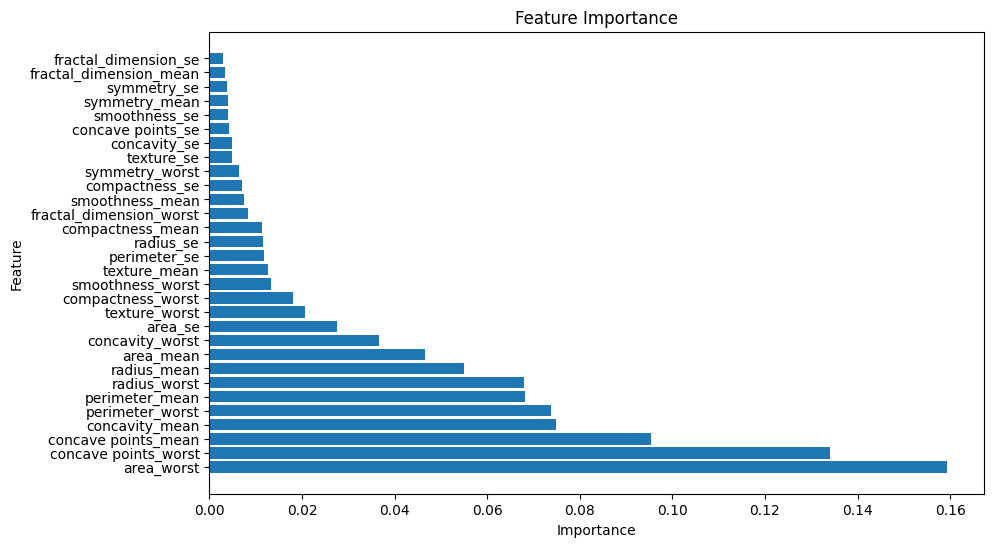

In [25]:
X = X_train.copy()
y = y_train.copy()

rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_

# Ranking Features.
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]

# Visualization.
plt.figure(figsize=(10, 6))
plt.barh(sorted_features,
         feature_importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

As observed, the most significant features to determine the diagnosis are, in order of significance; *area_worst*, *concave points_worst*, *concave points_mean*, *concavity_mean*, *perimeter_worst* and *radius_worst*.

##### Permutation Feature Importance with RF

Let's now evaluate feature importance using a technique called Permutation feature importance. When computing permutation importance, the model's performance metric (e.g., accuracy, mean squared error) is evaluated before and after shuffling the values of a feature. The difference between these two performances indicates the importance of the feature: if shuffling the feature values leads to a significant decrease in performance, the feature is considered important. In this case the already trained Random Forest Classifier will serve as the model.

Advantages:
- Provides a model-agnostic measure of feature importance by evaluating the effect of shuffling each feature on model performance.
- Can handle any type of model and is not biased towards specific types of features.
- Reflects the impact of each feature on the specific model's performance.

Considerations:
- Computationally more expensive, especially for large datasets or complex models.
- May require more careful interpretation, especially when there are strong correlations between features. Permutation feature importance is less affected by correlation among features compared to Random Forest feature importance. Since permutation feature importance evaluates the effect of shuffling each feature on model performance, it directly measures the impact of each feature on the model's predictive performance, regardless of correlations. However, if two features are highly correlated, permuting one feature may have a similar effect on model performance as permuting the other, leading to similar or identical importance scores for both features.

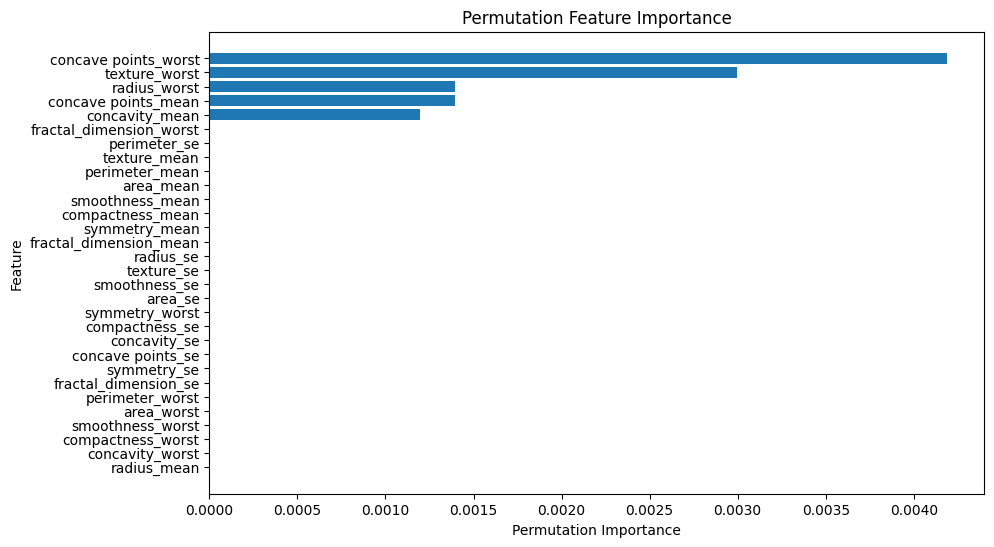

In [26]:
X = X_train.copy()
y = y_train.copy()

perm_importance = permutation_importance(rf_classifier,
                                         X,
                                         y,
                                         n_repeats=10,
                                         random_state=RANDOM_STATE)

# Ranking.
feature_names = X.columns
sorted_idx = perm_importance.importances_mean.argsort()

# Visualization.
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx],
         perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()

It seems that for the specific case of a Random Forest Classifier, the most significant variables are *concave points_worst*, *texture_worst*, *concavity_worst*, *fractal_dimension_se*, *area_se*, *smoothness_se*, *radius_se* and *concave points_mean*. 

A decision tree-based model like Random Forest may assign higher importance to certain features compared to a linear model like Logistic Regression. This difference arises because decision trees split the data based on feature values, making certain features more influential for prediction, whereas linear models estimate coefficients for each feature based on their relationship with the target variable. Let's redo the analysis using a logistic regression classifier. 

##### Logistic Regression

To perform feature importance analysis using Logistic Regression, the coefficients of the logistic regression model will serve as a measure of feature importance. Features with higher absolute coefficients are considered more important for predicting the target variable.

Advantatges:
- Coefficients directly indicate the impact of each feature on the target variable.
- Logistic Regression can capture nonlinear relationships through feature engineering.

Considerations:
- Logistic Regression assumes a linear relationship between features and the log-odds of the target variable.
- Outliers can disproportionately influence coefficient estimates.
- Logistic Regression assumes additive effects of features and may not capture complex interactions.

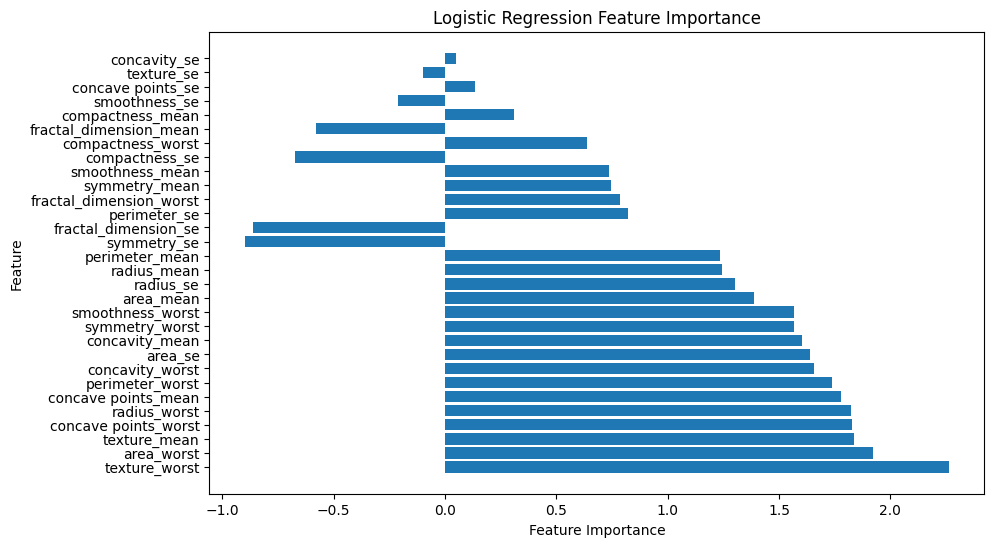

In [27]:
X = X_train.copy()
y = y_train.copy()

logreg_model = LogisticRegression(random_state=RANDOM_STATE)
logreg_model.fit(X, y)

feature_importance = logreg_model.coef_[0]

# Ranking Features.
sorted_indices = np.argsort(np.abs(feature_importance))[::-1]
sorted_features = X.columns[sorted_indices]

# Visualization.
plt.figure(figsize=(10, 6))
plt.barh(sorted_features,
         feature_importance[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()

The variables with higher coefficients are *texture_worst*, *area_worst*, *concave points_worst*, *radius_worst*, *concave points_mean*, *smoothness_worst*, *texture_mean*, *perimeter_worst*, *area_se*, *concavity_worst*, *concavity_mean*, *radius_se* and *area_mean*.

##### Permutation Feature Importance on LR

Let's now use the permutation importance technique with our Logistic Regression Classifier. 

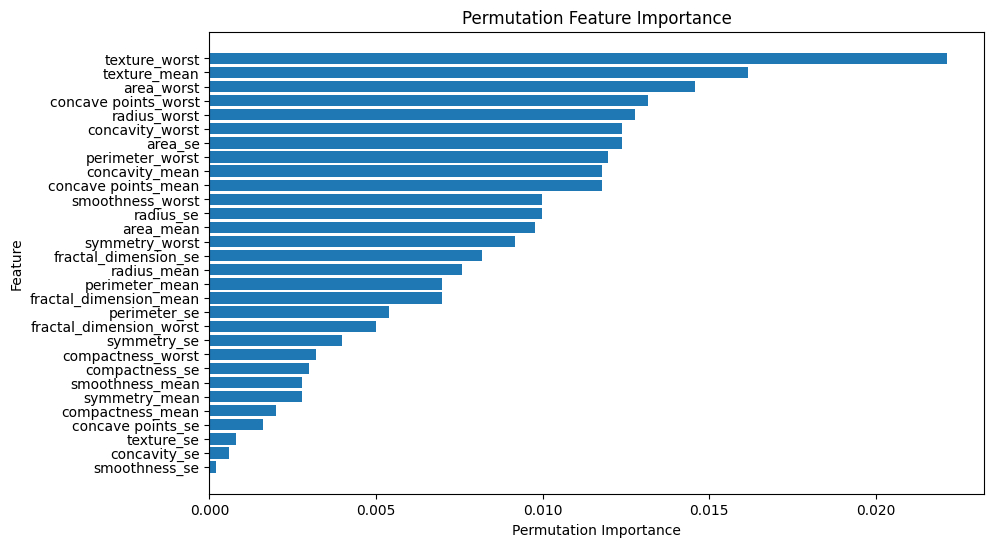

In [28]:
X = X_train.copy()
y = y_train.copy()

perm_importance = permutation_importance(logreg_model,
                                         X,
                                         y,
                                         n_repeats=10,
                                         random_state=RANDOM_STATE)

feature_names = X.columns
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx],
         perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()

It can be observed that for this type of classifier, there are more variables that contribute at model's predictions. From them, the most relevant ones are *texture_worst*, *texture_mean*, *concavity_worst*, *concave_points_worst*, *concavity_mean*, *smoothness_worst*, *area_se*, *concave_points_mean*, *symmetry_worst*, *area_worst* and *radius_worst*.

##### Elastic Net Regression

Elastic Net combines L1 and L2 regularization penalties, allowing it to handle multicollinearity more robustly than Lasso regression alone. It can effectively select a subset of features while also reducing the impact of highly correlated predictors. Elastic Net is a regularization technique that combines both L1 (Lasso) and L2 (Ridge) penalties in the loss function. This combination allows Elastic Net to handle multicollinearity among features and perform feature selection by shrinking coefficients and encouraging sparsity.

Advantages: 
- Handles multicollinearity well, provides variable selection through sparsity, suitable for high-dimensional datasets, interpretable model with some coefficients set to zero.
- Can easily be used for feature selection because it shrinks the coefficients of irrelevant variables to zero.

Considerations:
- Requires hyperparameter tuning, computationally intensive for large datasets, benefits from feature scaling, parameter selection can be challenging.

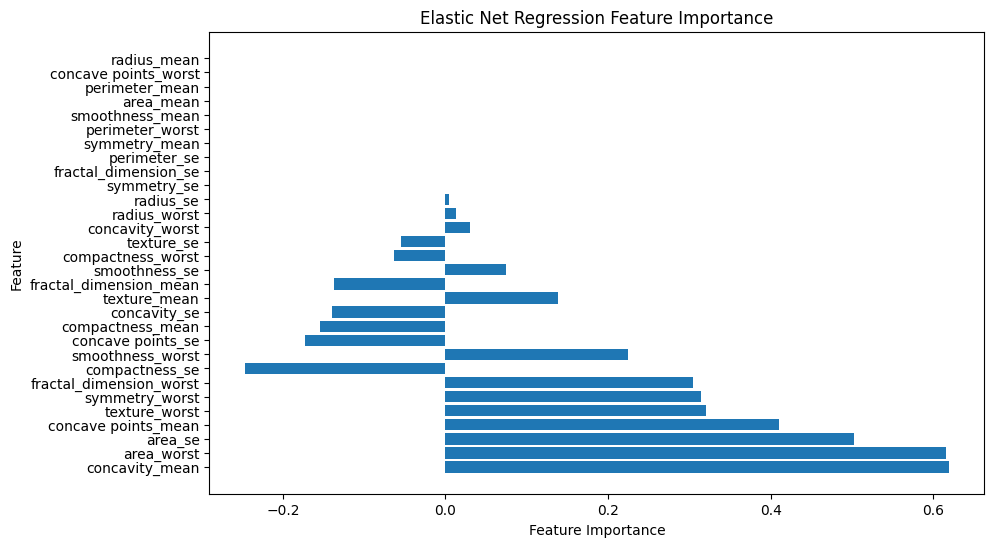

In [29]:
X = X_train.copy()
y = y_train.copy()

alpha = 0.001  # Regularization strength.
l1_ratio = 0.5  # Mixing parameter, 0 for L2 penalty, 1 for L1 penalty.
elastic_net_model = ElasticNet(alpha=alpha,
                               l1_ratio=l1_ratio,
                               random_state=RANDOM_STATE)
elastic_net_model.fit(X, y)

feature_importance = elastic_net_model.coef_

# Ranking Features.
sorted_indices = np.argsort(np.abs(feature_importance))[::-1]
sorted_features = X.columns[sorted_indices]

# Visualization.
plt.figure(figsize=(10, 6))
plt.barh(sorted_features,
         feature_importance[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Elastic Net Regression Feature Importance')
plt.show()

The most relevant features by importance are: *concavity_mean*, *area_worst*, *area_se*, *texture_worst*, *soothness_worst*, *symmetry_worst*, *concavity_se*, *compactness_mean*, *concave points_mean* and *fractal_dimension_worst*.

##### Feature Importance Conclusions

From the analysis, it seems that more or less the same variables appear as the most relevant. It is important to note that some of them are also highly correlated between eachother as seen in the Correlation Analysis during EDA, therefore, it could be useful to apply dimensionality reduction to reduce redundancy and improve model interpretability.

The less significant variables that **could be excluded** during feature selection, are: **symmetry_se**, **fractal_dimension_se**, **perimeter_se**, **radius_se**, ***fractal_dimension_mean***, ***symmetry_mean***, ***smoothness_mean***, ***compactness_worst***, ***perimeter_mean***, ***area_mean*** and **radius_mean**.

## Dimensionality reduction methods

When dealing with highly correlated features, using dimensionality reduction techniques could help effectively handle multicollinearity and preserve the essential information in the data. Let's explore if these methods could be of help with the provided data.

##### Partial Least Squares Regression (PLS)

Partial Least Squares Regression (PLS) is a regression-based technique that aims to find latent variables (components) that maximize the covariance between the predictors and the target variable. Unlike PCA, which focuses solely on maximizing variance, PLS considers the relationship between predictors and the target variable. PLS can be useful when there is a strong correlation between predictors and when the goal is to build predictive models.

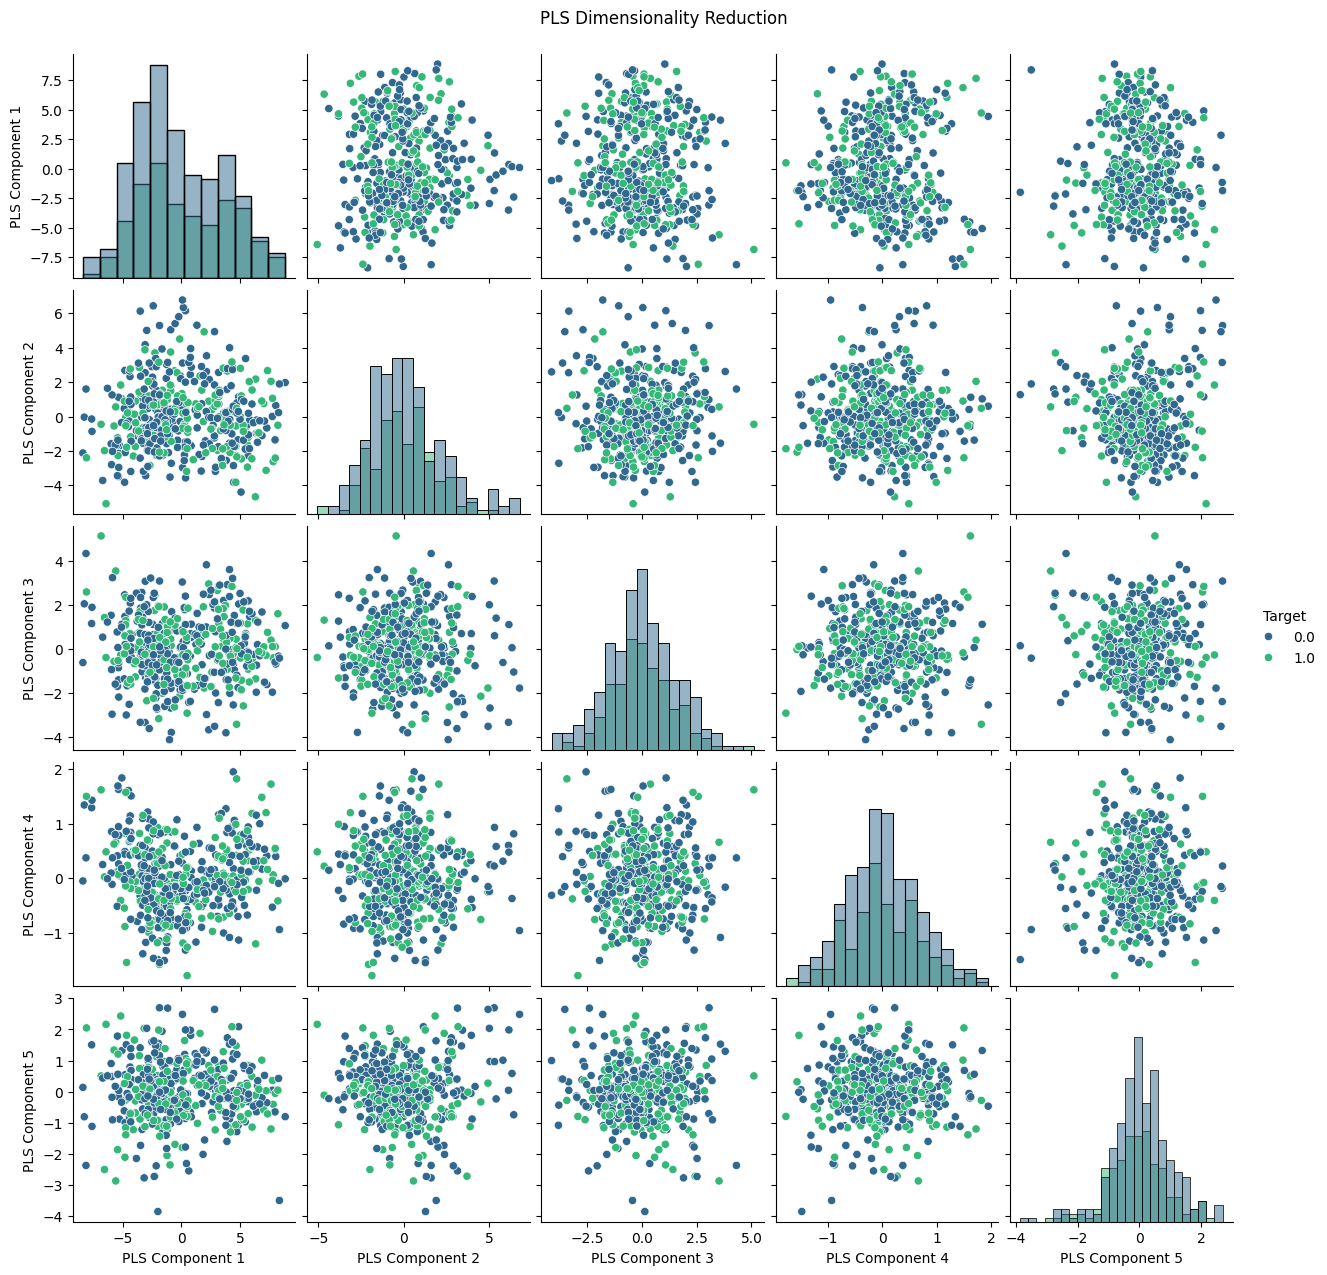

In [30]:
X = X_train.copy()
y = y_train.copy()

n_components = 5  # Number of components to keep.
pls = PLSRegression(n_components=n_components)
pls.fit(X, y)

# Transform the training and testing data to the PLS space.
X_pls = pls.transform(X)
# X_test_pls = pls.transform(X_test_scaled)

# Convert transformed data to DataFrame for easier visualization.
pls_df = pd.DataFrame(X_pls,
                      columns=[f'PLS Component {i+1}' for i in range(n_components)])
pls_df['Target'] = y

# Visualize the transformed data using a scatter plot matrix.
sns.pairplot(pls_df,
             hue='Target',
             palette='viridis',
             diag_kind='hist',
             diag_kws={'alpha': 0.5})
plt.suptitle('PLS Dimensionality Reduction', y=1.02)
plt.show()

Resulting components do not present any apparent pattern to differentiate target classes, therefore, this technique does not appear to be useful for this data. 

##### Principal Component Analysis (PCA)

PCA, or Principal Component Analysis, is a dimensionality reduction technique used to simplify the complexity of high-dimensional datasets while preserving most of the variability present in the data. It works by transforming the original variables into a new set of orthogonal variables called principal components. These principal components are ordered by the amount of variance they explain in the data, with the first component explaining the most variance, the second component explaining the second most variance, and so on.

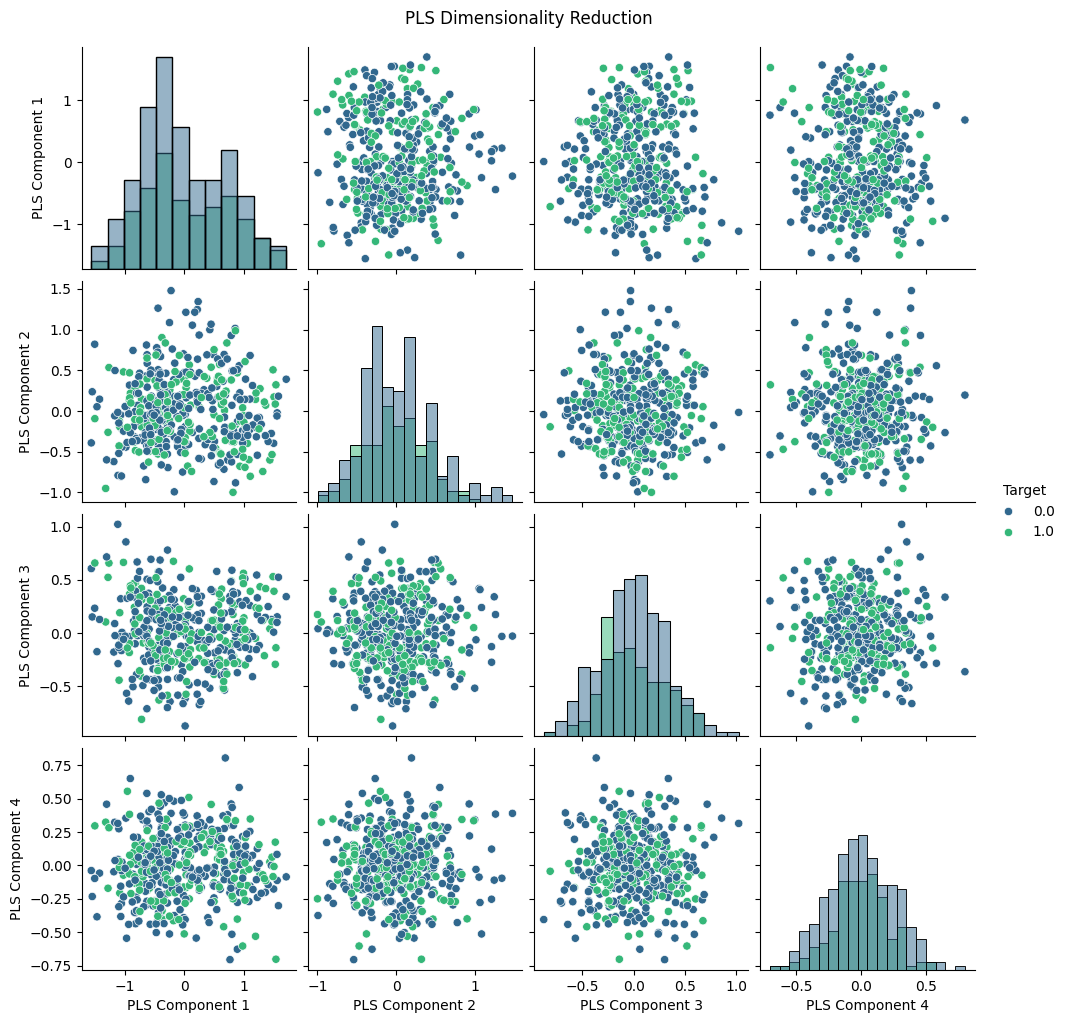

In [31]:
X = X_train.copy()
y = y_train.copy()

n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X, y)

# Transform the training data to the CCA space.
X_pca = pca.transform(X)

# Convert transformed data to DataFrame for easier visualization.
cca_df = pd.DataFrame(X_pca,
                      columns=[f'PLS Component {i+1}' for i in range(n_components)])
cca_df['Target'] = y

# Visualize the transformed data using a scatter plot matrix.
sns.pairplot(cca_df,
             hue='Target',
             palette='viridis',
             diag_kind='hist',
             diag_kws={'alpha': 0.5})
plt.suptitle('PLS Dimensionality Reduction', y=1.02)
plt.show()

Once again, resulting components do not present any visual pattern that could indicate that applying this technique would improve predictive power.

##### Reducing dimensionality Conclusions

No studied methods for reducing dimensionality have proved useful, therefore the strategy to reduce the number of features/inputs for the model will be focused on feature selection.

## Feature Selection

Since the goal is to test different ML models, let's avoid tailoring the feature selection to a specific model and let's try ensambling feature selection by combining the results of different feature selection algorithms. This approach will allow help leverage their respective strengths and mitigate their weaknesses.

The feature selection methods that will be ensambled are the ones used for assessing feature importance:

- Random Forest 
- Logistic Regresion coeficients
- Elastic Net Regression

In [32]:
X = X_train.copy()
y = y_train.copy()

print(f'There are {len(X.columns)} features prior to feature selection.')

# Models for feature selection to ensamble.
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
logistic_model = LogisticRegression(random_state=RANDOM_STATE)
elasticnet_model = ElasticNet(random_state=RANDOM_STATE)

feature_selector = FeatureSelectorEnsemble([rf_model,
                                            logistic_model,
                                            elastic_net_model],
                                            13, # max_features number of features to take.
                                            2) # Number of times a feature has to be voted to be selected.

X = feature_selector.fit_transform(X, y)

print(f'There are {len(X.columns)} features after feature selection.')

print('Features selected:')
print(X.columns)

There are 30 features prior to feature selection.
There are 12 features after feature selection.
Features selected:
Index(['area_mean', 'concavity_mean', 'concave points_mean', 'area_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst'],
      dtype='object')


##### Saving dataset after feature selection

In [33]:
# Save datasets as a pickle file
with open('outputs/processed_and_reduced_dataset.pkl', 'wb') as f:
    pickle.dump((X,
                 y,
                 feature_selector.transform(X_test),
                 y_test), f)